In [1]:
import pandas as pd

df = pd.read_csv('dump.csv')

df.head()

columns_to_drop = ["Unnamed: 0", "companyUrn", "mbrLocationCode", "posLocationCode", "companyUrl"]
df_cleaned = df.drop(columns=columns_to_drop)
df_cleaned = df_cleaned.drop_duplicates()

# convert date to datetime format
df_cleaned["startDate"] = pd.to_datetime(df_cleaned["startDate"], errors="coerce")
df_cleaned["endDate"] = pd.to_datetime(df_cleaned["endDate"], errors="coerce")

# creating a new column to determine if presently employed
df_cleaned["currently_employed"] = df_cleaned["endDate"].isna()

# remove rows with missing data
df_cleaned = df_cleaned.dropna(subset=["posTitle", "companyName", "startDate"])

# employed and unemployed groups
df_employed = df_cleaned[df_cleaned["currently_employed"] == True]
df_unemployed = df_cleaned[df_cleaned["currently_employed"] == False]

# percentage of users currently employed
employment_rate = df_cleaned["currently_employed"].mean() * 100

# employment rate shown
df_cleaned.info()
print(f"Percentage of users currently employed: {employment_rate:.2f}%")

<class 'pandas.core.frame.DataFrame'>
Index: 39519 entries, 0 to 39536
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ageEstimate            39519 non-null  float64       
 1   companyFollowerCount   38056 non-null  float64       
 2   companyHasLogo         36393 non-null  object        
 3   companyName            39519 non-null  object        
 4   companyStaffCount      38385 non-null  float64       
 5   connectionsCount       39519 non-null  float64       
 6   country                39519 non-null  object        
 7   endDate                30625 non-null  datetime64[ns]
 8   followable             39519 non-null  float64       
 9   followersCount         39519 non-null  float64       
 10  genderEstimate         35551 non-null  object        
 11  hasPicture             29592 non-null  object        
 12  isPremium              39519 non-null  float64       
 13  mbrLoc

In [ ]:
df_unemployed.describe()

In [ ]:
df_employed.describe()

In [7]:
# Compare average age, followers, gender breakdown, isPremium rate, isFollowable, and skills
comparison_metrics = {
    "Average Age": [df_unemployed["ageEstimate"].mean(), df_employed["ageEstimate"].mean()],
    "Average Followers": [df_unemployed["followersCount"].mean(), df_employed["followersCount"].mean()],
    "Gender Breakdown": [df_unemployed["genderEstimate"].value_counts(normalize=True), df_employed["genderEstimate"].value_counts(normalize=True)],
    "Is Premium Rate": [df_unemployed["isPremium"].mean(), df_employed["isPremium"].mean()],
    "Is Followable Rate": [df_unemployed["followable"].mean(), df_employed["followable"].mean()],
    "Average Skills Count": [df_unemployed["avgMemberPosDuration"].mean(), df_employed["avgMemberPosDuration"].mean()]
}

comparison_df = pd.DataFrame(comparison_metrics, index=["Unemployed", "Employed"])
print(comparison_df)

            Average Age  Average Followers  \
Unemployed    38.528229        1165.716343   
Employed      38.117270        1334.689454   

                                             Gender Breakdown  \
Unemployed  genderEstimate
male      0.674161
female    0....   
Employed    genderEstimate
male      0.656344
female    0....   

            Is Premium Rate  Is Followable Rate  Average Skills Count  
Unemployed         0.129796            0.947298            836.800614  
Employed           0.132449            0.960198           1010.190338  


In [8]:
# weighted formula (avgMemberPosDuration = experience)
weights = {
    "ageEstimate": 0.1,
    "followersCount": 0.2,
    "isPremium": 0.15,
    "followable": 0.1,
    "avgMemberPosDuration": 0.35,
    "genderEstimate": 0.1
}

def calculate_weighted_score(df):
    return (
        df["ageEstimate"].fillna(0) * weights["ageEstimate"] +
        df["followersCount"].fillna(0) * weights["followersCount"] +
        df["isPremium"].fillna(0) * weights["isPremium"] +
        df["followable"].fillna(0) * weights["followable"] +
        df["avgMemberPosDuration"].fillna(0) * weights["avgMemberPosDuration"]
    )

df_cleaned["weighted_score"] = calculate_weighted_score(df_cleaned)

# average weighted scores
df_weighted_scores = df_cleaned.groupby("currently_employed")["weighted_score"].mean()
print(df_weighted_scores)

currently_employed
False    529.990506
True     615.646625
Name: weighted_score, dtype: float64


DataFrame shape: (39519, 24)

DataFrame columns: ['ageEstimate', 'companyFollowerCount', 'companyHasLogo', 'companyName', 'companyStaffCount', 'connectionsCount', 'country', 'endDate', 'followable', 'followersCount', 'genderEstimate', 'hasPicture', 'isPremium', 'mbrLocation', 'mbrTitle', 'memberUrn', 'posLocation', 'posTitle', 'positionId', 'startDate', 'avgMemberPosDuration', 'avgCompanyPosDuration', 'currently_employed', 'weighted_score']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
Index: 39519 entries, 0 to 39536
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ageEstimate            39519 non-null  float64       
 1   companyFollowerCount   38056 non-null  float64       
 2   companyHasLogo         36393 non-null  object        
 3   companyName            39519 non-null  object        
 4   companyStaffCount      38385 non-null  float64       
 5   connectionsCount

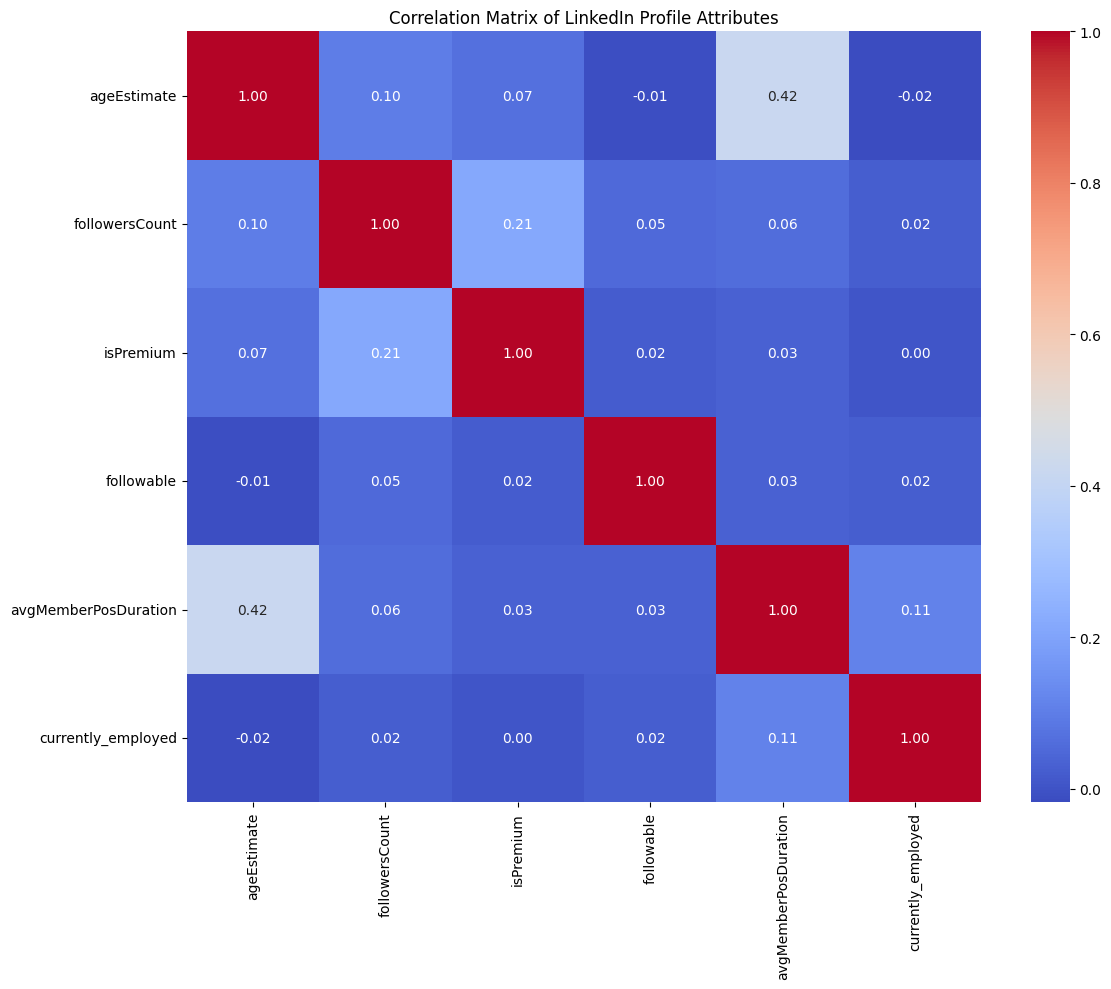

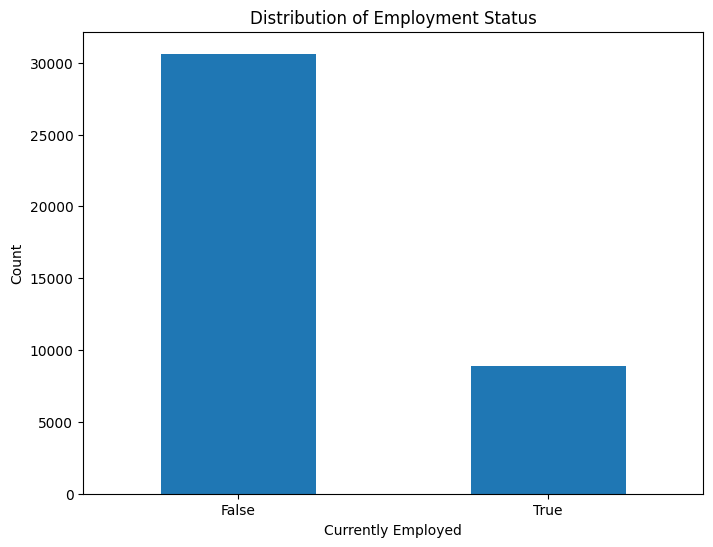

MissingDataError: exog contains inf or nans

In [10]:
# LinkedIn Profile Attributes - Regression Analysis
# This notebook analyzes which LinkedIn profile attributes best explain hiring outcomes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming df_cleaned is your dataframe with the LinkedIn profile data
# If you need to load the data from a CSV file, uncomment and modify the line below
# df_cleaned = pd.read_csv('your_linkedin_data.csv')

# Check basic statistics and structure of the data
print("DataFrame shape:", df_cleaned.shape)
print("\nDataFrame columns:", df_cleaned.columns.tolist())
print("\nDataFrame info:")
df_cleaned.info()
print("\nSummary statistics:")
print(df_cleaned.describe())

# Check for missing values
print("\nMissing values per column:")
print(df_cleaned.isnull().sum())

# Fill missing values if needed
# Example: df_cleaned = df_cleaned.fillna(0)

# Visualize correlation between variables
plt.figure(figsize=(12, 10))
correlation_matrix = df_cleaned[["ageEstimate", "followersCount", "isPremium", "followable", 
                                 "avgMemberPosDuration", "currently_employed"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of LinkedIn Profile Attributes')
plt.tight_layout()
plt.show()

# Distribution of employment status
plt.figure(figsize=(8, 6))
df_cleaned['currently_employed'].value_counts().plot(kind='bar')
plt.title('Distribution of Employment Status')
plt.xlabel('Currently Employed')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Prepare features (X) and target variable (y)
X = df_cleaned[["ageEstimate", "followersCount", "isPremium", "followable", "avgMemberPosDuration"]]
y = df_cleaned["currently_employed"]

# Create a statistical model with statsmodels for detailed statistics
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
print("\nDetailed Regression Results:")
print(model.summary())

# Calculate R-squared for individual variables to see their individual contribution
individual_r2 = {}
for column in X.columns:
    X_single = sm.add_constant(df_cleaned[[column]])
    model_single = sm.OLS(y, X_single).fit()
    individual_r2[column] = model_single.rsquared

print("\nR-squared for individual variables:")
for var, r2 in individual_r2.items():
    print(f"{var}: {r2:.4f}")

# Sort variables by their R-squared value
sorted_r2 = sorted(individual_r2.items(), key=lambda x: x[1], reverse=True)
print("\nVariables ranked by R-squared (highest to lowest):")
for var, r2 in sorted_r2:
    print(f"{var}: {r2:.4f}")

# Use scikit-learn for predictions and additional metrics
lr_model = LinearRegression()
lr_model.fit(X, y)

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

print("\nFeature coefficients (sorted):")
print(coefficients)

# Make predictions
y_pred = lr_model.predict(X)

# Calculate R-squared and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"\nModel R-squared: {r2:.4f}")
print(f"Root Mean Square Error: {rmse:.4f}")

# Compare with the weighted scores approach from the original code
weights = {
    "ageEstimate": 0.1,
    "followersCount": 0.2,
    "isPremium": 0.15,
    "followable": 0.1,
    "avgMemberPosDuration": 0.45
}

def calculate_weighted_score(df):
    return (
        df["ageEstimate"].fillna(0) * weights["ageEstimate"] +
        df["followersCount"].fillna(0) * weights["followersCount"] +
        df["isPremium"].fillna(0) * weights["isPremium"] +
        df["followable"].fillna(0) * weights["followable"] +
        df["avgMemberPosDuration"].fillna(0) * weights["avgMemberPosDuration"]
    )

df_cleaned["weighted_score"] = calculate_weighted_score(df_cleaned)

# Calculate R-squared for the weighted score approach
X_weighted = sm.add_constant(df_cleaned[['weighted_score']])
model_weighted = sm.OLS(y, X_weighted).fit()
print("\nWeighted Score Approach R-squared:", model_weighted.rsquared)

# Average weighted scores by employment status
df_weighted_scores = df_cleaned.groupby("currently_employed")["weighted_score"].mean()
print("\nAverage weighted scores by employment status:")
print(df_weighted_scores)

# Visualize feature importance
plt.figure(figsize=(10, 6))
coefficients.plot(x='Feature', y='Coefficient', kind='bar')
plt.title('Feature Importance in Predicting Employment Status')
plt.ylabel('Coefficient Value')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create scatterplots for each feature vs employment status
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X.columns):
    plt.subplot(2, 3, i+1)
    plt.scatter(df_cleaned[feature], y, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Currently Employed')
    plt.title(f'{feature} vs Employment Status')
    
    # Add regression line
    z = np.polyfit(df_cleaned[feature], y, 1)
    p = np.poly1d(z)
    plt.plot(sorted(df_cleaned[feature]), p(sorted(df_cleaned[feature])), "r--")
    
plt.tight_layout()
plt.show()

# Compare predicted probabilities with weighted scores
plt.figure(figsize=(10, 6))
plt.scatter(df_cleaned['weighted_score'], y, alpha=0.3, label='Actual')
plt.scatter(df_cleaned['weighted_score'], y_pred, alpha=0.3, label='Predicted')
plt.xlabel('Weighted Score')
plt.ylabel('Employment Status')
plt.title('Weighted Score vs Employment Status')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
df_weighted_scores.head()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


X = df_cleaned[['ageEstimate', 'followersCount', 'isPremium', 'followable', 'avgMemberPosDuration']]
y = df_cleaned['weighted_score']

# linreg
model = LinearRegression()
model.fit(X, y)

# r-squared/coef
coefficients = model.coef_
intercept = model.intercept_
r_squared = model.score(X, y)

# results
print("Regression Results:")
print(f"Intercept: {intercept}")
feature_names = X.columns
for i, feature in enumerate(feature_names):
    print(f"{feature}: {coefficients[i]}")
print(f"R-squared: {r_squared}")


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns



# relative weights
abs_coefficients = np.abs(coefficients)
relative_importance = abs_coefficients / np.sum(abs_coefficients)

print("\nRelative Importance of Variables:")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {relative_importance[i] * 100:.2f}%")

# graphing
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': relative_importance * 100
}).sort_values('Importance', ascending=False)

ax = sns.barplot(x='Feature', y='Importance', data=importance_df)
plt.xlabel('Features')
plt.ylabel('Relative Importance (%)')
plt.title('Feature Importance in Weighted Score Formula')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns



original_weights = {
    "ageEstimate": 0.1,
    "followersCount": 0.2,
    "isPremium": 0.15,
    "followable": 0.1,
    "avgMemberPosDuration": 0.45
}

# arbitrary weights vs. comparison
original_weights_values = np.array(list(original_weights.values()))
normalized_original = original_weights_values / np.sum(original_weights_values)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Feature': feature_names,
    'Original Weight (%)': [original_weights[feat] * 100 for feat in feature_names],
    'Regression Weight (%)': coefficients * 100,
    'Original Normalized (%)': normalized_original * 100,
    'Regression Importance (%)': relative_importance * 100
})

print("\nComparison of Original Weights vs. Regression Coefficients:")
print(comparison_df)

# correlation
corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Explanatory Variables')
plt.tight_layout()
plt.show()

# graph 2
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

In [ ]:
# Do a correlation matrix
# Does the data have to be normally distributed